In [1]:
import numpy as np
import pyaudio
import wave 
from pydub import AudioSegment
import os
from pydub.playback import play
import matplotlib.pyplot as plt
import tensorflow as tf

D:\ACCS\Voice_commands\custom\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def record(command):
    # Record in chunks of 1024 samples
    chunk = 1024
    # 16 bits per sample
    sample_format = pyaudio.paInt16
    channels = 1
    sample_rate = 16000
    seconds = 1.5
    filename = os.path.join("audio", "{}.wav".format(command))

    # Create an interface to PortAudio
    pa = pyaudio.PyAudio()
    stream = pa.open(format = sample_format, channels = channels,
                    rate = sample_rate, input = True, frames_per_buffer = chunk)
    print("Recording...")
    # Initialize array that be used for storing frames
    frames = [] 

    for i in range(0, int(sample_rate / chunk * seconds)):
        data = stream.read(chunk)
        frames.append(data)

    stream.stop_stream()
    stream.close()
    # Terminate - PortAudio interface
    pa.terminate()

    print("Done !!!")

    # Save the recorded data in a .wav format
    sf = wave.open(filename, 'wb')
    sf.setnchannels(channels)
    sf.setsampwidth(pa.get_sample_size(sample_format))
    sf.setframerate(sample_rate)
    sf.writeframes(b''.join(frames))
    sf.close()
    return filename

def match_target_amplitude(aChunk, target_dBFS):
    change_in_dBFS = target_dBFS - aChunk.dBFS
    return aChunk.apply_gain(change_in_dBFS)

def playAudio(filename):
    tape = AudioSegment.from_wav(filename)
    play(tape)
    
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents = audio_binary)
    return tf.squeeze(audio, axis = -1)

def get_waveform(filepath):
    audio_binary = tf.io.read_file(filepath)
    waveform = decode_audio(audio_binary)
    return waveform

def get_spectrogram(waveform):
    waveform = tf.cast(waveform, dtype = tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length = 255, frame_step = 188)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [3]:
commands = [('One', 'audio\\One.wav'), ('Two', 'audio\\Two.wav'), ('Three', 'audio\\Three.wav'),
            ('Off', 'audio\\Off.wav'), ('Start', 'audio\\Start.wav'), ('Stop', 'audio\\Stop.wav'),
            ('Up', 'audio\\Up.wav'), ('Down', 'audio\\Down.wav'), ('Wiper', 'audio\\Wiper.wav'),
            ('Window', 'audio\\Window.wav'), ('Engine', 'audio\\Engine.wav')]
for command in commands:
    playAudio(command[1])
    playAudio("beep.wav")

## Visualising the Commands sounds

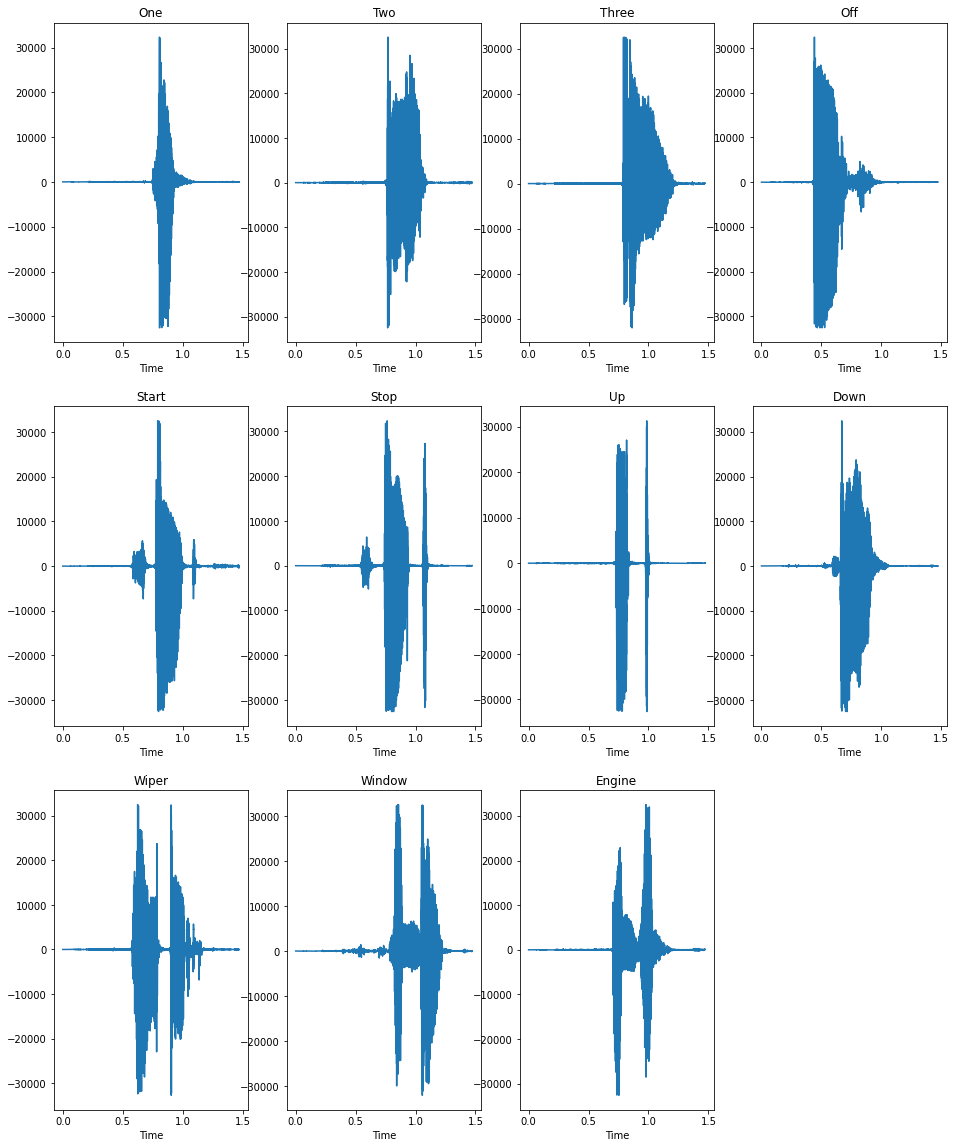

In [4]:
plt.figure(figsize=(16,20)) 
for i, command in enumerate(commands):
    raw = wave.open(command[1])
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype = 'int16')
    frameRate = raw.getframerate()
    time = np.linspace(0, len(signal)/frameRate, num = len(signal))
    plt.subplot(3, 4, i+1)
    plt.plot(time, signal)
    plt.xlabel("Time")
    plt.title(command[0])
plt.show()

## Frequency analysis of Commands

#### Audio 1 "One"

In [5]:
test_file = tf.io.read_file(os.path.join("audio", "One.wav"))
test_audio, _ = tf.audio.decode_wav(contents = test_file)
test_audio.shape

TensorShape([23552, 1])

In [6]:
waveform1 = get_waveform(os.path.join("audio", "One.wav"))
spectrogram1 = get_spectrogram(waveform1)

In [7]:
spectrogram1.shape

TensorShape([124, 129, 1])

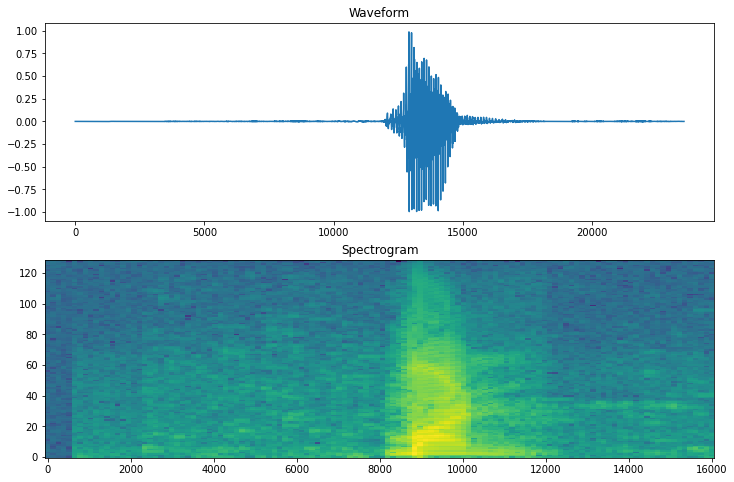

In [8]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform1.shape[0])
axes[0].plot(timescale, waveform1.numpy())
axes[0].set_title('Waveform')

plot_spectrogram(spectrogram1.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

#### Audio 2 "Two"

In [9]:
test_file = tf.io.read_file(os.path.join("audio", "Two.wav"))
test_audio, _ = tf.audio.decode_wav(contents = test_file)
test_audio.shape

TensorShape([23552, 1])

In [10]:
waveform2 = get_waveform(os.path.join("audio", "Two.wav"))
spectrogram2 = get_spectrogram(waveform2)

In [11]:
spectrogram2.shape

TensorShape([124, 129, 1])

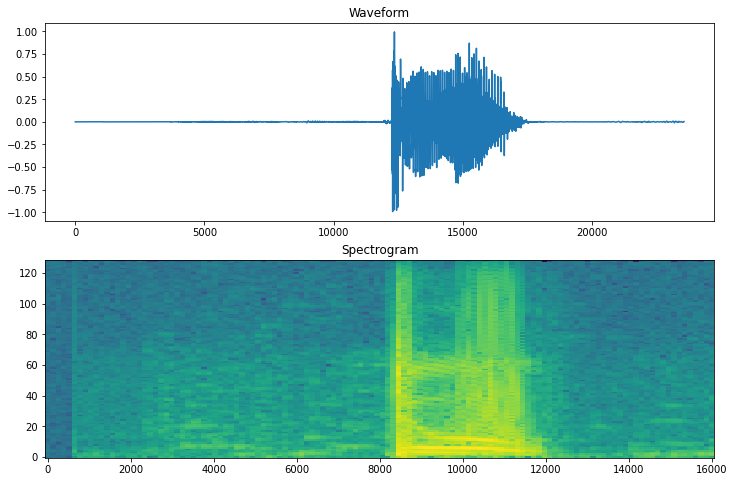

In [12]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform2.shape[0])
axes[0].plot(timescale, waveform2.numpy())
axes[0].set_title('Waveform')

plot_spectrogram(spectrogram2.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

#### All Commands

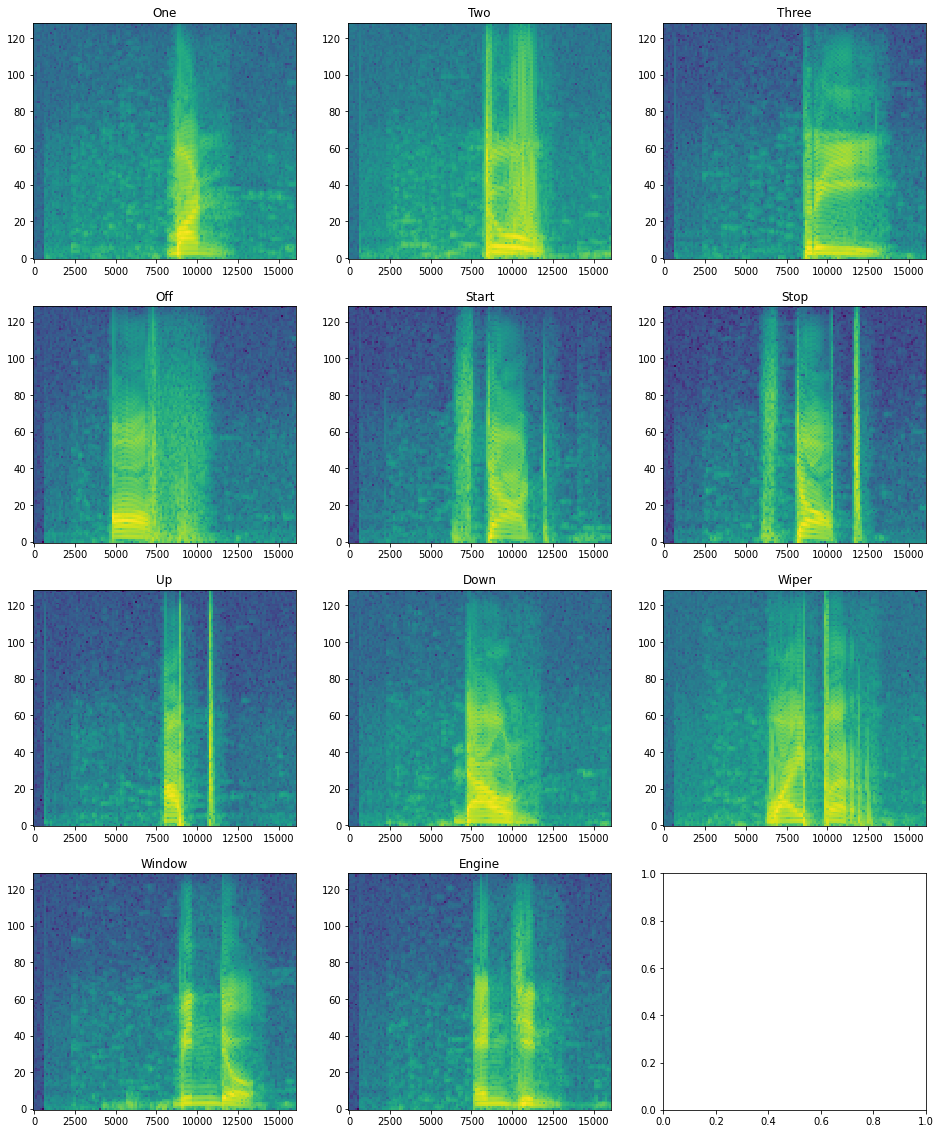

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(16,20))
spectrograms = []
for i, command in enumerate(commands):
    waveform = get_waveform(command[1])
    spectrogram = get_spectrogram(waveform)
    spectrograms.append(spectrogram)
j = 0
for ho in axes:
    for i in ho:
        if j == 11:
            break
        plot_spectrogram(spectrograms[j].numpy(), i)
        i.set_title(commands[j][0])
        j = j + 1
        
plt.show()

In [14]:
w_start = get_waveform(os.path.join('audio', 'Start.wav'))
s_start = get_spectrogram(w_start)
start = s_start.numpy()

In [15]:
w_stop = get_waveform(os.path.join('audio', 'Stop.wav'))
s_stop = get_spectrogram(w_stop)
stop = s_stop.numpy()

Text(0.5, 1.0, 'Stop')

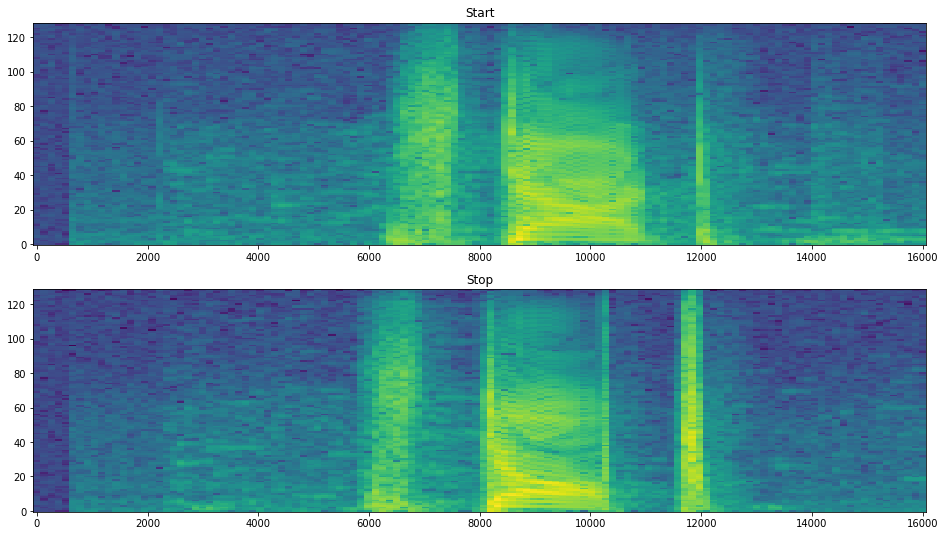

In [16]:
fig, axes = plt.subplots(2, 1, figsize = (16, 9))
plot_spectrogram(start, axes[0])
axes[0].set_title("Start")
plot_spectrogram(stop, axes[1])
axes[1].set_title("Stop")

#### Complete Pipeline

In [17]:
def pipeline(size, *args):
    fig, axes = plt.subplots(len(args), 1, figsize = size)
    for i, name in enumerate(args):
        waveform = get_waveform(os.path.join('audio', name))
        spectrogram = get_spectrogram(waveform)
        plot_spectrogram(spectrogram, axes[i])
        axes[i].set_title(name.split('.')[0])

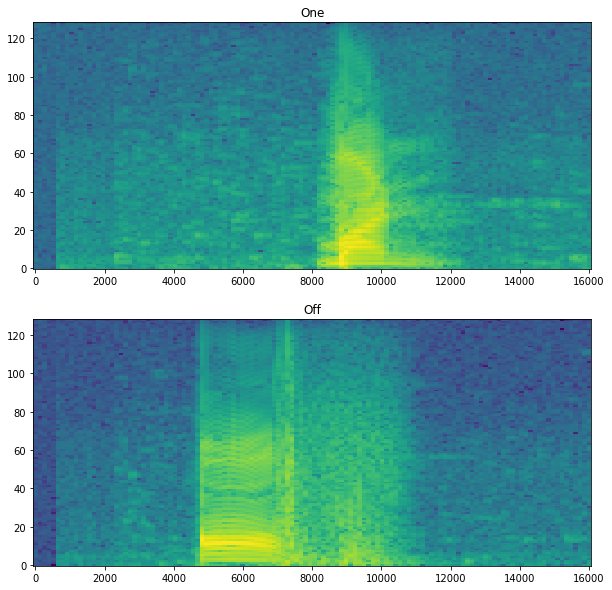

In [18]:
pipeline((10, 10), 'One.wav', 'Off.wav')

#### Analysis of "Start" and "Stop"

In [19]:
label_names = ['Start1', 'Stop1', 'Start2', 'Stop2', 'Start3', 'Stop3' ]
commands_ss = []
input("Press Enter key to start recording...")
for command in label_names:
    print("Say '{}'".format(command))
    input("Press Enter key to continue...")
    file = record(command)
    commands_ss.append((command, file))

print(commands_ss)

Press Enter key to start recording... 


Say 'Start1'


Press Enter key to continue... 


Recording...
Done !!!
Say 'Stop1'


Press Enter key to continue... 


Recording...
Done !!!
Say 'Start2'


Press Enter key to continue... 


Recording...
Done !!!
Say 'Stop2'


Press Enter key to continue... 


Recording...
Done !!!
Say 'Start3'


Press Enter key to continue... 


Recording...
Done !!!
Say 'Stop3'


Press Enter key to continue... 


Recording...
Done !!!
[('Start1', 'audio\\Start1.wav'), ('Stop1', 'audio\\Stop1.wav'), ('Start2', 'audio\\Start2.wav'), ('Stop2', 'audio\\Stop2.wav'), ('Start3', 'audio\\Start3.wav'), ('Stop3', 'audio\\Stop3.wav')]


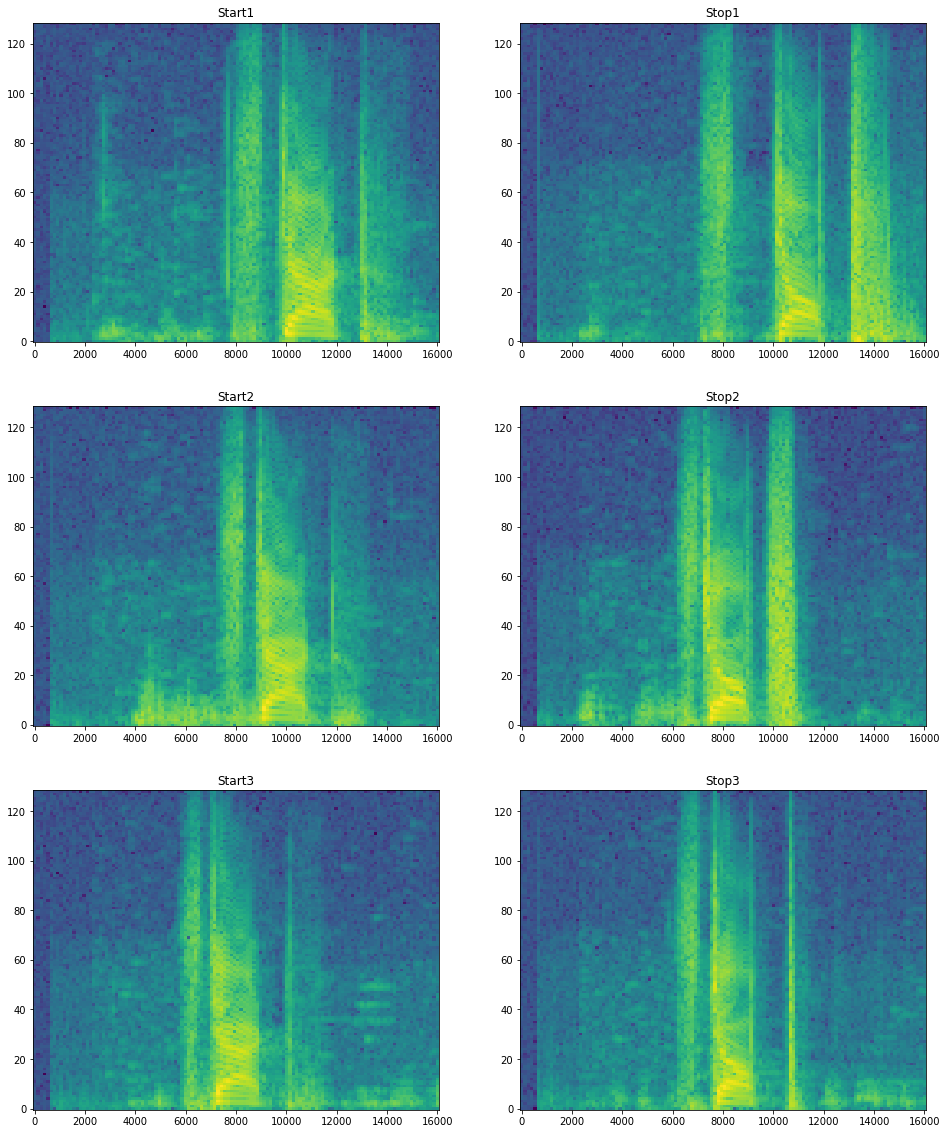

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(16,20))
spectrograms = []
for i, command in enumerate(commands_ss):
    waveform = get_waveform(command[1])
    spectrogram = get_spectrogram(waveform)
    spectrograms.append(spectrogram)
j = 0
for ho in axes:
    for i in ho:
        plot_spectrogram(spectrograms[j].numpy(), i)
        i.set_title(commands_ss[j][0])
        j = j + 1
        
plt.show()

In [21]:
for command in commands_ss:
    playAudio(command[1])
    playAudio("beep.wav")

In [22]:
label_names = ['On1', 'Off1', 'On2', 'Off2', 'On3', 'Off3' ]
commands_oo = []
input("Press Enter key to start recording...")
for command in label_names:
    print("Say '{}'".format(command))
    input("Press Enter key to continue...")
    file = record(command)
    commands_oo.append((command, file))

print(commands_oo)

Press Enter key to start recording... 


Say 'On1'


Press Enter key to continue... 


Recording...
Done !!!
Say 'Off1'


Press Enter key to continue... 


Recording...
Done !!!
Say 'On2'


Press Enter key to continue... 


Recording...
Done !!!
Say 'Off2'


Press Enter key to continue... 


Recording...
Done !!!
Say 'On3'


Press Enter key to continue... 


Recording...
Done !!!
Say 'Off3'


Press Enter key to continue... 


Recording...
Done !!!
[('On1', 'audio\\On1.wav'), ('Off1', 'audio\\Off1.wav'), ('On2', 'audio\\On2.wav'), ('Off2', 'audio\\Off2.wav'), ('On3', 'audio\\On3.wav'), ('Off3', 'audio\\Off3.wav')]


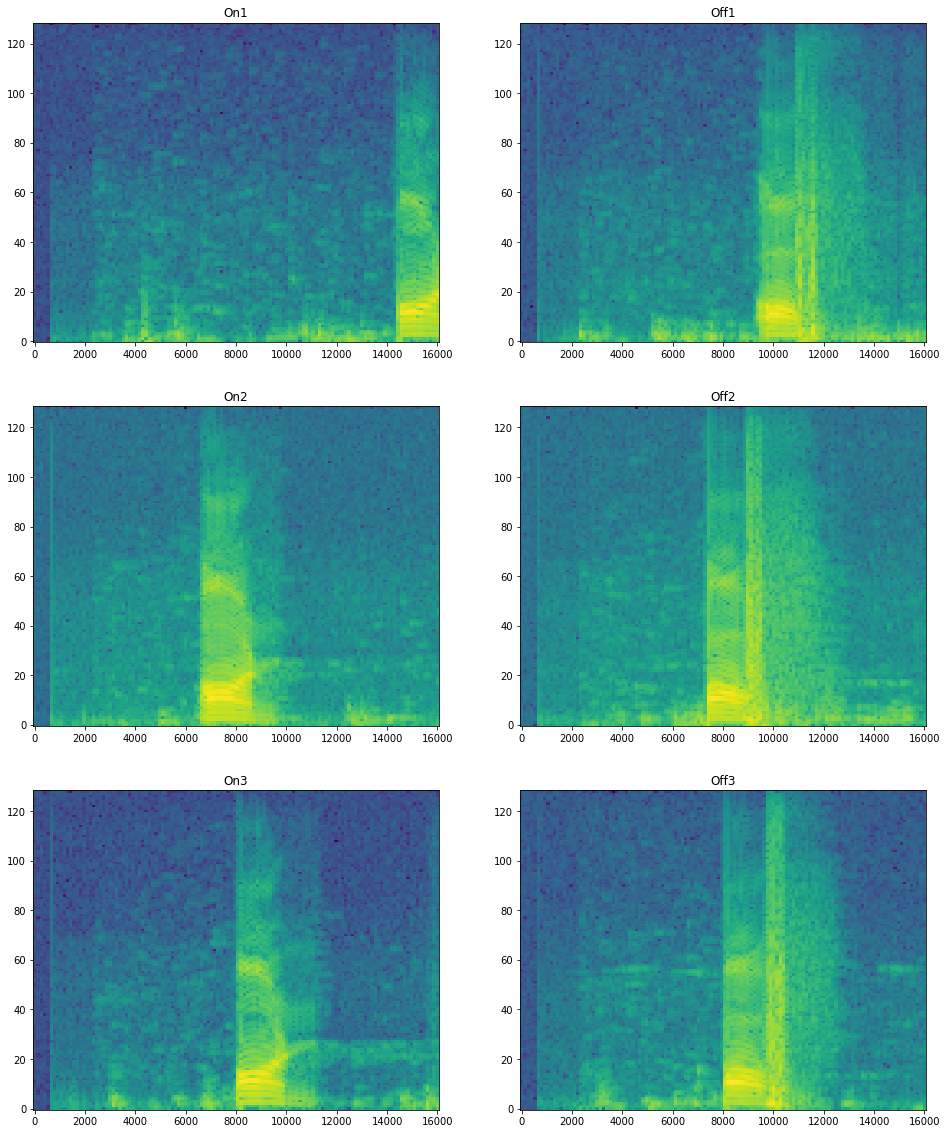

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(16,20))
spectrograms = []
for i, command in enumerate(commands_oo):
    waveform = get_waveform(command[1])
    spectrogram = get_spectrogram(waveform)
    spectrograms.append(spectrogram)
j = 0
for ho in axes:
    for i in ho:
        plot_spectrogram(spectrograms[j].numpy(), i)
        i.set_title(commands_oo[j][0])
        j = j + 1
        
plt.show()

In [3]:
file = record("dow10")

Recording...
Done !!!
